In [1]:
!nvidia-smi

Fri Nov  6 12:06:10 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.32.00    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   58C    P8    10W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [17]:
import os
import numpy as np
import pickle
import pandas as pd
import matplotlib.pyplot as plt
from scipy import signal, spatial, stats
from fastdtw import fastdtw
from scipy.signal import find_peaks
import pywt
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
import keras
from scipy.interpolate import CubicSpline      # for warping
from keras.layers import Input, Dense, Conv1D, Conv2D, MaxPooling2D, MaxPooling1D, Flatten, Dropout, BatchNormalization, Reshape
from keras.models import Model
from sklearn.preprocessing import OneHotEncoder
from keras.optimizers import Adam
from keras.losses import CategoricalCrossentropy, BinaryCrossentropy
from keras.metrics import Accuracy, Precision, Recall
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras import Sequential

In [5]:
os.chdir('gdrive/My Drive/Weave/Earables Project/Final Experiments/')

In [6]:
data = pickle.load(open('data/processed_df.pkl', 'rb'))
fold_idx = pickle.load(open('data/5_fold_idx.pkl', 'rb'))

In [7]:
test_fold_i = 3
train_idx, test_idx =[], []
for i, idx in enumerate(fold_idx):
    if i == test_fold_i:
        test_idx.append(idx)
    else:
        train_idx.append(idx)
train_idx = np.concatenate(train_idx)
test_idx = np.concatenate(test_idx)
print('train: {}, test: {}'.format(len(train_idx), len(test_idx)))
X_train = data.loc[train_idx].iloc[:,:-3].to_numpy()
y_train = data.loc[train_idx].iloc[:,-3:-2]
X_test = data.loc[test_idx].iloc[:,:-3].to_numpy()
y_test = data.loc[test_idx].iloc[:,-3:-2]
ohe = OneHotEncoder()
y_train = ohe.fit_transform(y_train).toarray()
y_test = ohe.transform(y_test).toarray()

train: 14984, test: 3746


In [8]:
tmp = []
for i in range(len(X_train)):
    ch = []
    for j in range(12):
        ch.append(X_train[i][j])
    ch = np.array(ch).T
    tmp.append(ch)
X_train = np.array(tmp)

tmp = []
for i in range(len(X_test)):
    ch = []
    for j in range(12):
        ch.append(X_test[i][j])
    ch = np.array(ch).T
    tmp.append(ch)
X_test = np.array(tmp)
del tmp, ch
print(X_train.shape)
print(X_test.shape)

(74918, 100, 12)
(18730, 100, 12)


In [9]:
n_classes = y_train.shape[1]
print('num. of classes: {}'.format(n_classes))

num. of classes: 32


In [13]:
def build_model(input_shape, nb_classes):
    model = Sequential(name = 'conv2d_12ch')
    model.add(Input(shape=input_shape, name='input'))
    model.add(Reshape((input_shape[0], input_shape[1], 1)))
    model.add(Conv2D(64, kernel_size=3, activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(128, kernel_size=2, activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(256, kernel_size=2, activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 1)))

    model.add(Flatten())
    model.add(Dense(2000, activation='relu'))
    model.add(Dense(500, activation='relu'))
    model.add(Dense(nb_classes, activation = 'sigmoid'))

    return model

In [14]:
input_shape = (100, 12)
model = build_model(input_shape, n_classes)
model.summary()

Model: "conv2d_12ch"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_1 (Reshape)          (None, 100, 12, 1)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 98, 10, 64)        640       
_________________________________________________________________
batch_normalization_3 (Batch (None, 98, 10, 64)        256       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 49, 5, 64)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 48, 4, 128)        32896     
_________________________________________________________________
batch_normalization_4 (Batch (None, 48, 4, 128)        512       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 24, 2, 128)        

In [12]:
batch_size = 32

In [18]:
model_name = 'conv2d_sigmoid_f3'
optimizer = Adam(learning_rate=0.001)
# loss = BinaryCrossentropy()
# model.load_weights('checkpoint/{}.h5'.format(model_name))
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics='accuracy')
checkpoint = ModelCheckpoint('checkpoint/{}.h5'.format(model_name), monitor='val_loss', verbose=1, mode='min',save_best_only=True)
earlystopping = EarlyStopping(monitor='val_loss', patience=20, verbose=1)
reducelr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, verbose=1, min_lr=0.000001)

(74918, 100, 12)
(18730, 100, 12)


In [19]:
history = model.fit(X_train, y_train,
                    validation_data=(X_test, y_test),
                    batch_size=batch_size,
                    epochs=100,
                    # workers=4,
                    callbacks=[checkpoint, earlystopping, reducelr],
                    shuffle=True)

Epoch 1/100
2342/2342 [==============================] - ETA: 0s - loss: 0.1008 - accuracy: 0.3326
Epoch 00001: val_loss improved from inf to 0.08499, saving model to checkpoint/conv2d_sigmoid_f3.h5
2342/2342 [==============================] - 15s 6ms/step - loss: 0.1008 - accuracy: 0.3326 - val_loss: 0.0850 - val_accuracy: 0.4387
Epoch 2/100
2337/2342 [============================>.] - ETA: 0s - loss: 0.0625 - accuracy: 0.5865
Epoch 00002: val_loss improved from 0.08499 to 0.06392, saving model to checkpoint/conv2d_sigmoid_f3.h5
2342/2342 [==============================] - 16s 7ms/step - loss: 0.0625 - accuracy: 0.5865 - val_loss: 0.0639 - val_accuracy: 0.5855
Epoch 3/100
2338/2342 [============================>.] - ETA: 0s - loss: 0.0445 - accuracy: 0.7192
Epoch 00003: val_loss improved from 0.06392 to 0.05049, saving model to checkpoint/conv2d_sigmoid_f3.h5
2342/2342 [==============================] - 15s 7ms/step - loss: 0.0445 - accuracy: 0.7192 - val_loss: 0.0505 - val_accuracy: 

In [ ]:
pred = model.predict(X_test)

In [ ]:
ohe.categories_[0][1]

'10'

              precision    recall  f1-score   support

           0       0.95      0.98      0.96       375
           1       0.87      0.90      0.89       640
           2       0.89      0.90      0.90       450
           3       0.88      0.89      0.89       670
           4       0.93      0.91      0.92       625
           5       0.87      0.85      0.86       610
           6       0.92      0.90      0.91       640
           7       0.86      0.89      0.88       570
           8       0.92      0.90      0.91       605
           9       0.91      0.90      0.90       675
          10       0.91      0.92      0.92       640
          11       0.88      0.87      0.88       615
          12       0.91      0.90      0.91       675
          13       0.84      0.87      0.85       590
          14       0.91      0.89      0.90       685
          15       0.82      0.86      0.84       605
          16       0.90      0.93      0.92       570
          17       0.89    

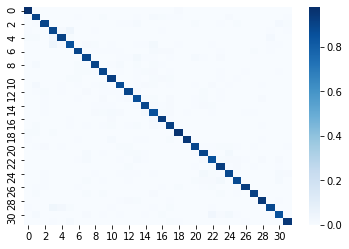

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

y_pred = [np.argmax(p) for p in pred]
y_true = [np.argmax(p) for p in y_test]
cf_mat = confusion_matrix(y_true, y_pred, normalize='true')
print(classification_report(y_true, y_pred))
sns.heatmap(cf_mat, cmap='Blues')

In [ ]:
pickle.dump(cf_mat, open('tcn1_all_confusion_matrix.pkl', 'wb'))